In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [2]:
from zipfile import ZipFile

fill_name = "archive.zip"

with ZipFile(fill_name, 'r') as zip:
  zip.extractall()

  print("çıkartma işlemi tamamlandı")


çıkartma işlemi tamamlandı


In [3]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [4]:
train_dir = "train"
val_dir = "test"

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size =(48,48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size =(48,48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [6]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)


emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=7178 // 64,
        callbacks=[earlystopping])

<ipython-input-6-f39dc75f68b4>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


Epoch 1/100
448/448 [==============================] - 17s 25ms/step - loss: 1.7127 - accuracy: 0.3071 - val_loss: 1.5281 - val_accuracy: 0.4235
Epoch 2/100
448/448 [==============================] - 10s 23ms/step - loss: 1.4330 - accuracy: 0.4455 - val_loss: 1.3127 - val_accuracy: 0.4920
Epoch 3/100
448/448 [==============================] - 10s 22ms/step - loss: 1.2983 - accuracy: 0.5042 - val_loss: 1.2174 - val_accuracy: 0.5308
Epoch 4/100
448/448 [==============================] - 10s 22ms/step - loss: 1.2185 - accuracy: 0.5371 - val_loss: 1.1623 - val_accuracy: 0.5585
Epoch 5/100
448/448 [==============================] - 10s 22ms/step - loss: 1.1634 - accuracy: 0.5609 - val_loss: 1.1379 - val_accuracy: 0.5710
Epoch 6/100
448/448 [==============================] - 10s 22ms/step - loss: 1.1190 - accuracy: 0.5780 - val_loss: 1.1145 - val_accuracy: 0.5753
Epoch 7/100
448/448 [==============================] - 10s 22ms/step - loss: 1.0725 - accuracy: 0.5915 - val_loss: 1.0976 - val_ac

In [7]:
emotion_model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [9]:
import matplotlib.pyplot as plt

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('yüzdesel oranlar')
    plt.title('Duygular')
    plt.show()

In [10]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):

  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();


      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);


      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

In [13]:
import urllib.request

url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
filename = "/content/haarcascade_frontalface_default.xml"

urllib.request.urlretrieve(url, filename)

import cv2
from google.colab.patches import cv2_imshow


image_path = "images.jpg"
img = cv2.imread(image_path)



face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))


for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)


if len(faces) > 0:
    x, y, w, h = faces[0]
    green_frame = img[y:y+h, x:x+w]
    cv2.imwrite('yuz_cercevesi.jpg', green_frame)


1/1 [==============================] - 0s 330ms/step


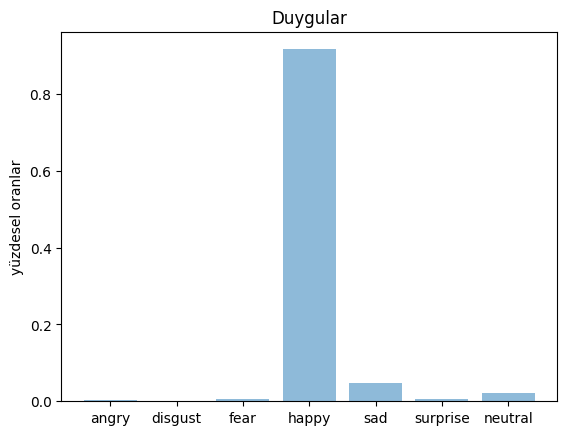

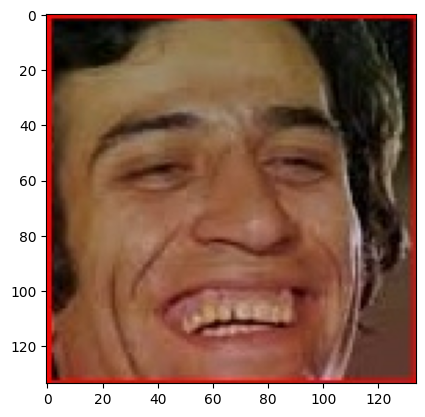

In [14]:
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = 'yuz_cercevesi.jpg'

true_image = image.load_img(file)

img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))



x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = emotion_model.predict(x)

emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.imshow(true_image)
plt.show()
